# Exploring Dandiset 000563: Allen Institute Openscope - Barcoding

**A Practical Guide for Exploring and Reanalyzing Multi-modal Neuropixels Data**

---

**Notebook generated with the assistance of AI. Please review code and results carefully before drawing any scientific conclusions.**

---

## Overview of Dandiset 000563

This Dandiset presents data from the Allen Institute's OpenScope Barcoding project. The dataset features high-density Neuropixels recordings and multi-modal behavioral data from the mouse visual system, subjected to precisely-timed visual stimuli and optogenetic protocols.

- **Purpose:** To investigate temporal precision and spike “barcode” patterns across repeated visual white noise sequences, from retina to cortex.
- **Modalities:** Multi-electrode (Neuropixels) extracellular recordings, optogenetic data, running wheel, and camera-based eye tracking.
- **Main Data:** Neural spike units, extensive metadata, detailed stimulus presentations, running/eye-tracking behavior, and optogenetic epochs.
- **Special note:** LFP is stored in separate probe files (not shown here); be aware timestamps for LFP are in milliseconds, but all demonstration and exploration here focus on the core *_ogen.nwb files.

- **Dandiset Link:** [https://dandiarchive.org/dandiset/000563/0.250311.2145](https://dandiarchive.org/dandiset/000563/0.250311.2145)

---

## What this Notebook Covers

- How to connect to the DANDI API and list available NWB files in the dandiset.
- Inspection of the structure and key metadata of a main session file.
- Accessing and visualizing spike-sorted units & their firing properties.
- Exploring the structure of stimulus interval tables.
- Finding and visualizing stimulus-aligned spiking for responsive units.
- Accessing and visualizing behavioral (running, eye tracking) and optogenetic data.

Each section is designed to be a practical starting point for further exploration and reanalysis.

## Required Packages

The following Python packages are required to run this notebook:

- `dandi`
- `remfile`
- `h5py`
- `pynwb`
- `numpy`
- `pandas`
- `matplotlib`

Please ensure these packages are already installed in your environment.

## 1. Connect to DANDI and List NWB Session Files

The DANDI API makes it easy to remotely browse and stream data files for large neuroscience datasets.

In [1]:
from dandi.dandiapi import DandiAPIClient
from itertools import islice

# Connect to DANDI
client = DandiAPIClient()
dandiset_id = "000563"
dandiset_version = "0.250311.2145"
dandiset = client.get_dandiset(dandiset_id, dandiset_version)

# List all NWB session files. *_ogen.nwb contain most experimental data.
assets = list(dandiset.get_assets_by_glob("*.nwb"))
ogen_files = [a.path for a in assets if "ogen" in a.path]

print(f"Total NWB files: {len(assets)}")
print("First 10 NWB files:")
for a in islice(assets, 10):
    print(f"- {a.path}")

print("\nMain data files (contain 'ogen'):")
for p in ogen_files:
    print(f"- {p}")

Total NWB files: 94
First 10 NWB files:
- sub-699241/sub-699241_ses-1318772854_probe-1_ecephys.nwb
- sub-699241/sub-699241_ses-1318772854_probe-3_ecephys.nwb
- sub-699241/sub-699241_ses-1318772854_probe-4_ecephys.nwb
- sub-699241/sub-699241_ses-1318772854_probe-0_ecephys.nwb
- sub-699241/sub-699241_ses-1318772854_ogen.nwb
- sub-699241/sub-699241_ses-1318772854_probe-2_ecephys.nwb
- sub-699846/sub-699846_ses-1314466742_probe-1_ecephys.nwb
- sub-699846/sub-699846_ses-1314466742_probe-2_ecephys.nwb
- sub-699846/sub-699846_ses-1314466742_probe-4_ecephys.nwb
- sub-699846/sub-699846_ses-1314466742_probe-3_ecephys.nwb

Main data files (contain 'ogen'):
- sub-699241/sub-699241_ses-1318772854_ogen.nwb
- sub-699846/sub-699846_ses-1314466742_ogen.nwb
- sub-698259/sub-698259_ses-1314229564_ogen.nwb
- sub-692990/sub-692990_ses-1310924284_ogen.nwb
- sub-697302/sub-697302_ses-1309845146_ogen.nwb
- sub-697303/sub-697303_ses-1309536438_ogen.nwb
- sub-692360/sub-692360_ses-1301730660_ogen.nwb
- sub-6929

## 2. Load a Remote NWB File for Exploration

Here, we'll examine a single *_ogen.nwb file using streaming access. These files contain all major behavioral, neural, and stimulus tables for a given recording session.

*Note: We do not download the file in full; data are accessed on-demand via `remfile`.*

In [2]:
import h5py
import remfile
import pynwb

# Pick a representative *_ogen.nwb file
asset_path = ogen_files[0]
asset = next(dandiset.get_assets_by_glob(asset_path))

# Open a streaming file handle
remote_file = remfile.File(asset.download_url)
h5_file = h5py.File(remote_file, 'r')
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

print(f"NWB session loaded: {asset_path}")

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


NWB session loaded: sub-699241/sub-699241_ses-1318772854_ogen.nwb


## 3. Session and Subject Metadata Overview

Let's extract key metadata that helps contextualize the experiment, subject, and data availability for this file.

In [3]:
meta = {
    'session_id': nwb.session_id,
    'subject_id': nwb.subject.subject_id,
    'species': nwb.subject.species,
    'age': nwb.subject.age,
    'sex': nwb.subject.sex,
    'genotype': nwb.subject.genotype,
    'date': str(nwb.session_start_time.date()),
    'electrodes_count': nwb.electrodes.to_dataframe().shape[0],
    'units_count': nwb.units.to_dataframe().shape[0],
    'stimulus_kinds': list(nwb.intervals.keys()),
    'processing_modules': list(nwb.processing.keys()),
    'acquisition_timeseries': list(nwb.acquisition.keys())
}

print("Experiment/session summary:")
for k, v in meta.items():
    if isinstance(v, list):
        print(f"{k}: {', '.join(map(str, v))}")
    else:
        print(f"{k}: {v}")

Experiment/session summary:
session_id: 1318772854
subject_id: 699241
species: Mus musculus
age: P124D
sex: M
genotype: Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
date: 2023-12-19
electrodes_count: 1920
units_count: 2299
stimulus_kinds: RepeatFFF_presentations, UniqueFFF_presentations, invalid_times, receptive_field_block_presentations, static_block_presentations
processing_modules: optotagging, running, stimulus
acquisition_timeseries: EyeTracking, raw_running_wheel_rotation, running_wheel_signal_voltage, running_wheel_supply_voltage


## 4. Exploring Spike-Sorted Units

Each NWB file includes a large set of spike-sorted units. Below we show how to efficiently inspect their properties and firing rates. For large NWB files, avoid loading the full units table when possible.

Total spike-sorted units: 2299

Unit quality counts:
 quality
good     1892
noise     407
Name: count, dtype: int64


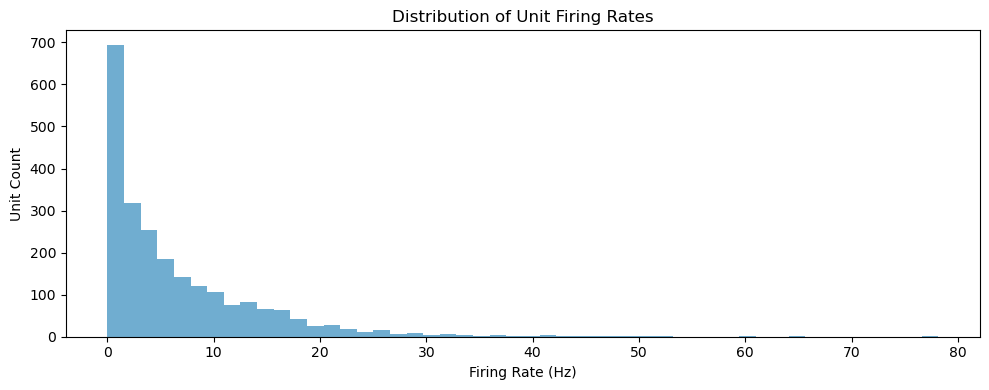

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Access firing rates and qualities efficiently
units_df = nwb.units.to_dataframe()
total_units = units_df.shape[0]
quality_counts = units_df['quality'].value_counts(dropna=False)
print(f"Total spike-sorted units: {total_units}")
print("\nUnit quality counts:\n", quality_counts)

# Show a histogram of firing rates
plt.figure(figsize=(10, 4))
plt.hist(units_df['firing_rate'].dropna(), bins=50, color="#348ABD", alpha=0.7)
plt.xlabel('Firing Rate (Hz)')
plt.ylabel('Unit Count')
plt.title('Distribution of Unit Firing Rates')
plt.tight_layout()
plt.show()

### Accessing Spike Times Efficiently

The correct way to access spike times for the i-th unit is with `nwb.units.spike_times_index[i]`.

Let's visualize spike rasters for the first five "good" units in a relevant window, automatically centered at the earliest spike across them.

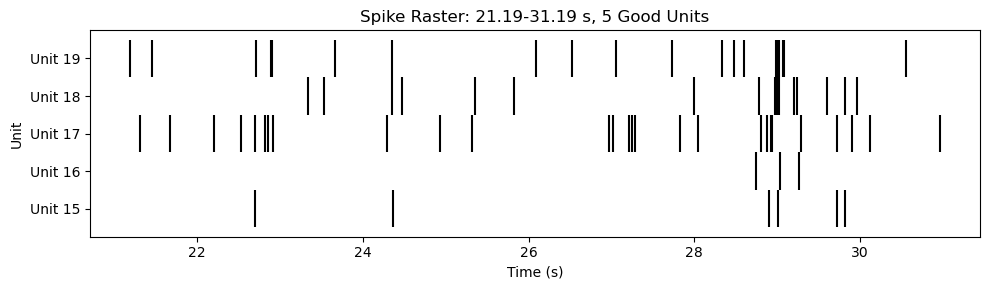

In [5]:
# Find indices of "good" units
all_qualities = nwb.units['quality'][:]
unit_ids = nwb.units.id[:]
good_idxs = [i for i, q in enumerate(all_qualities) if q == 'good']

# Pull spike trains for the first 5 good units
selected_idxs = good_idxs[:5]
spike_trains = [nwb.units.spike_times_index[i] for i in selected_idxs]

# Find earliest spike (across units) to center the raster window
all_spikes = np.concatenate(spike_trains) if spike_trains else np.array([])
if all_spikes.size == 0:
    print("No spikes found for these units.")
else:
    t_start = all_spikes.min()
    t_stop = t_start + 10          # Show 10 seconds window
    raster_spikes = [st[(st >= t_start) & (st < t_stop)] for st in spike_trains]

    plt.figure(figsize=(10, 3))
    for i, st in enumerate(raster_spikes):
        plt.vlines(st, i + 0.5, i + 1.5, color='k')
    plt.yticks(np.arange(1, 6), [f"Unit {unit_ids[idx]}" for idx in selected_idxs])
    plt.xlabel('Time (s)')
    plt.ylabel('Unit')
    plt.title(f'Spike Raster: {t_start:.2f}-{t_stop:.2f} s, 5 Good Units')
    plt.tight_layout()
    plt.show()

## 5. Exploring Stimulus Intervals

Stimulus blocks (e.g., RepeatFFF, UniqueFFF) are stored as interval tables. Each row corresponds to a precisely-timed trial with rich annotation (stimulus name, orientation, contrast, etc.).

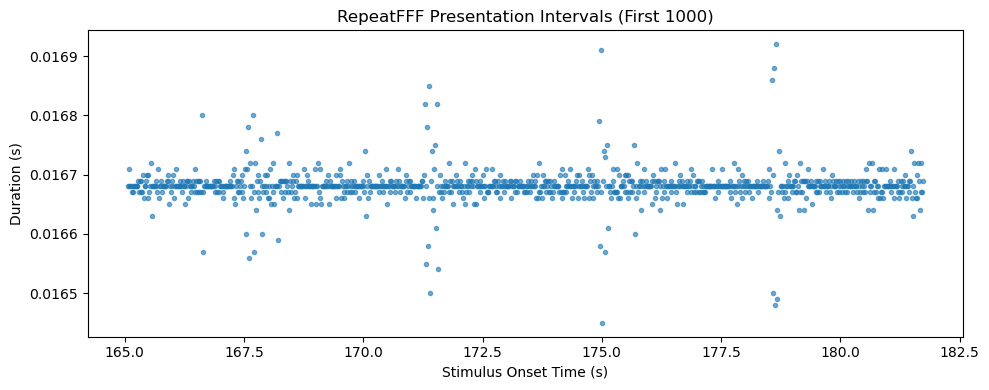

,contrast,orientation,spatial_frequency,size,phase,units
id,,,,,,
0,1.0,0.0,"[0.0, 0.0]","[250.0, 250.0]","[0.0, 0.0]",deg
1,1.0,0.0,"[0.0, 0.0]","[250.0, 250.0]","[0.0, 0.0]",deg
2,1.0,0.0,"[0.0, 0.0]","[250.0, 250.0]","[0.0, 0.0]",deg
3,1.0,0.0,"[0.0, 0.0]","[250.0, 250.0]","[0.0, 0.0]",deg
4,1.0,0.0,"[0.0, 0.0]","[250.0, 250.0]","[0.0, 0.0]",deg


In [6]:
import pandas as pd

repeatfff_df = nwb.intervals['RepeatFFF_presentations'].to_dataframe()
onsets = repeatfff_df['start_time'].values[:1000]
durations = (repeatfff_df['stop_time'] - repeatfff_df['start_time']).values[:1000]

plt.figure(figsize=(10, 4))
plt.plot(onsets, durations, '.', alpha=0.6)
plt.xlabel('Stimulus Onset Time (s)')
plt.ylabel('Duration (s)')
plt.title('RepeatFFF Presentation Intervals (First 1000)')
plt.tight_layout()
plt.show()

# Show some key stimulus properties
prop_cols = ['contrast', 'orientation', 'spatial_frequency', 'size', 'phase', 'units']
display(repeatfff_df[prop_cols].head())

## 6. Finding and Plotting Stimulus-Responsive Units

Demonstrate how to search for a unit whose spikes most reliably coincide with a stimulus window, and plot its aligned raster across multiple trials.

Best unit index: 549, spikes in window: 1079 (unit id: 565)


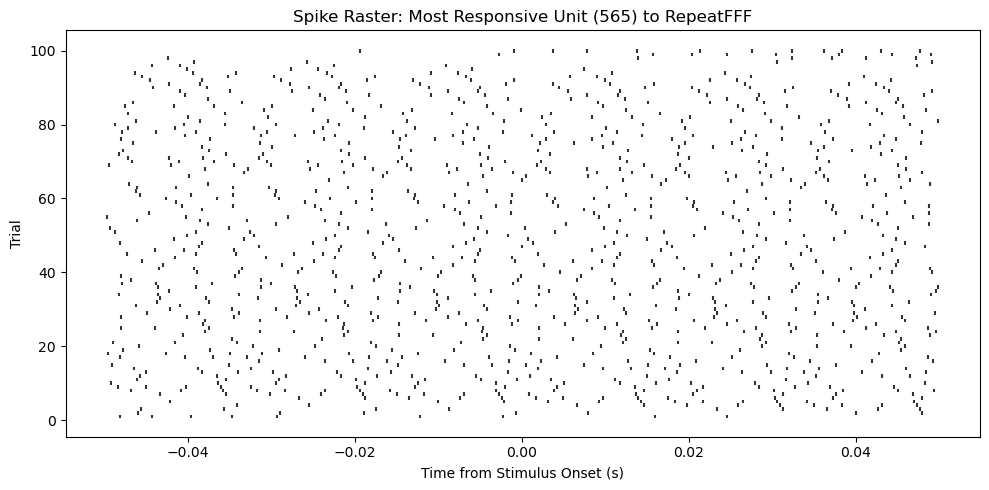

In [7]:
# We'll search for the unit with the most spikes in a ±50ms window around first 100 RepeatFFF intervals
epoch_onsets = repeatfff_df['start_time'].values[:100]
window = [-0.05, 0.05]

def count_aligned_spikes(spike_times, onsets, window):
    return sum(((spike_times >= onset + window[0]) & (spike_times < onset + window[1])).sum() for onset in onsets)

unit_spike_counts = []
for i in range(len(nwb.units.id)):
    st = nwb.units.spike_times_index[i]
    unit_spike_counts.append(count_aligned_spikes(st, epoch_onsets, window))

best_unit_idx = int(np.argmax(unit_spike_counts))
best_unit_id = nwb.units.id[best_unit_idx]
print(f"Best unit index: {best_unit_idx}, spikes in window: {unit_spike_counts[best_unit_idx]} (unit id: {best_unit_id})")

# Assemble aligned rasters
spike_times = nwb.units.spike_times_index[best_unit_idx]
rasters = [(spike_times[(spike_times >= onset + window[0]) & (spike_times < onset + window[1])] - onset)
           for onset in epoch_onsets]

plt.figure(figsize=(10, 5))
for i, spikes in enumerate(rasters):
    plt.vlines(spikes, i+0.5, i+1.5, color='k', alpha=0.8)
plt.xlabel('Time from Stimulus Onset (s)')
plt.ylabel('Trial')
plt.title(f'Spike Raster: Most Responsive Unit ({best_unit_id}) to RepeatFFF')
plt.tight_layout()
plt.show()

## 7. Accessing and Visualizing Behavioral Data

This section shows how to view running speed and eye tracking signals.

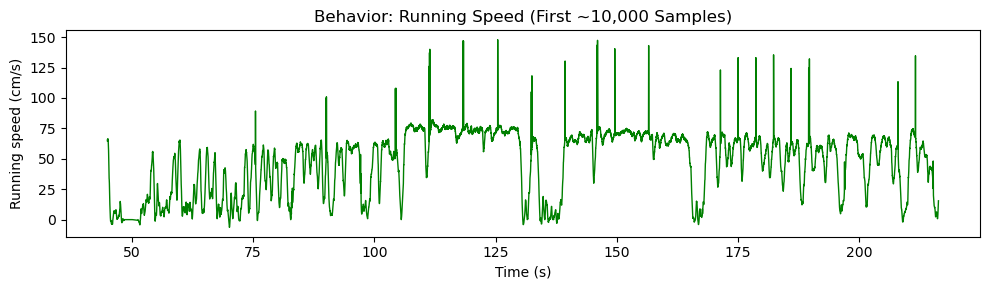

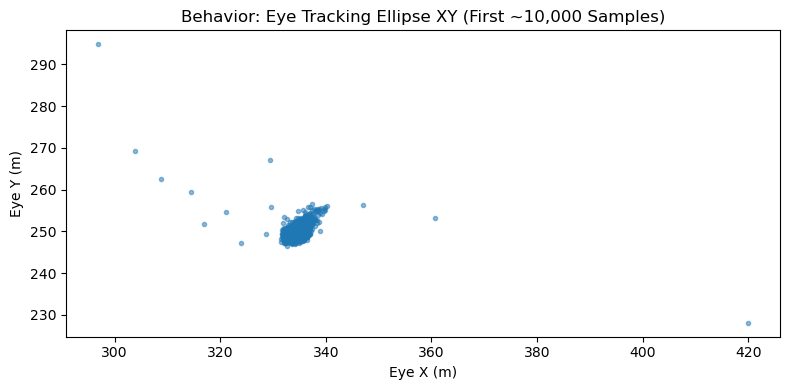

In [8]:
# Running speed (first 10,000 samples)
ts_running = nwb.processing['running'].data_interfaces['running_speed']
running_speed = ts_running.data[:10000]
running_time = ts_running.timestamps[:10000]  # seconds

plt.figure(figsize=(10, 3))
plt.plot(running_time, running_speed, color='green', lw=1)
plt.xlabel('Time (s)')
plt.ylabel('Running speed (cm/s)')
plt.title('Behavior: Running Speed (First ~10,000 Samples)')
plt.tight_layout()
plt.show()

# Eye tracking (first 10,000 samples)
eyedata = nwb.acquisition['EyeTracking'].eye_tracking.data[:10000]
plt.figure(figsize=(8, 4))
plt.plot(eyedata[:, 0], eyedata[:, 1], '.', alpha=0.5)
plt.xlabel('Eye X (m)')
plt.ylabel('Eye Y (m)')
plt.title('Behavior: Eye Tracking Ellipse XY (First ~10,000 Samples)')
plt.tight_layout()
plt.show()

## 8. Optogenetic Stimulation Epochs

Optogenetic stimulation intervals are organized as DataFrames for querying or state-alignment analyses.

In [9]:
opto_df = nwb.processing['optotagging'].data_interfaces['optogenetic_stimulation'].to_dataframe()
print(opto_df[['start_time', 'stop_time', 'level', 'stimulus_name']].head())

    start_time   stop_time  level      stimulus_name
id                                                  
0   7270.95571  7271.95571   1.94   5 hz pulse train
1   7273.09679  7274.09679   1.94      raised_cosine
2   7275.06681  7276.06681   2.05      raised_cosine
3   7276.87680  7277.87680   1.94   5 hz pulse train
4   7278.99756  7279.99756   2.05  40 hz pulse train


## 9. Summary and Next Steps

**In this notebook, you learned:**
- How to browse, open, and stream NWB files from Dandiset 000563 (Barcoding project).
- How to inspect metadata and file structure.
- How to access, filter, and visualize spike-sorted units and stimulus intervals.
- How to match neural activity to stimulus epochs and search for the most responsive cells.
- How to explore behavioral and optogenetic data streams for richer scientific questions.

**Potential next steps for your research:**
- Quantify temporal precision or reproducibility (barcode analysis).
- Analyze tuning or selectivity to features in the stimulus table.
- Segment by behavioral or optogenetic state.
- Adapt and extend plots for other sessions, units, or conditions in the Dandiset.

**Further resources:**
- Main Dandiset: [https://dandiarchive.org/dandiset/000563/0.250311.2145](https://dandiarchive.org/dandiset/000563/0.250311.2145)
- [NeuroSIFT visualization for NWB](https://neurosift.app/nwb?dandisetId=000563&dandisetVersion=0.250311.2145)

---

*Notebook generated with the assistance of AI. Please validate and interpret results using scientific best practices.*